Number of images in Normal class: 1589
Number of images in Osteoarthritis class: 2257


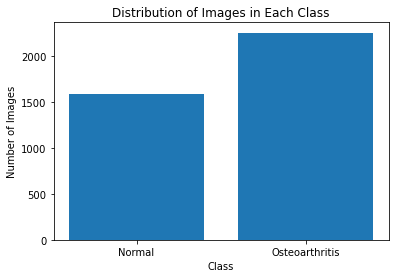

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
    return images

# Load images from directories for each class
normal_images = load_and_resize_images_from_folder('/home/lab5/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Normal')
osteoarthritis_images = load_and_resize_images_from_folder('/home/lab5/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Osteoarthritis')

# Display the number of images in each class
print("Number of images in Normal class:", len(normal_images))
print("Number of images in Osteoarthritis class:", len(osteoarthritis_images))

# Create a histogram to visualize the distribution of images in each class
plt.bar(['Normal', 'Osteoarthritis'], [len(normal_images), len(osteoarthritis_images)])
plt.title('Distribution of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


2024-03-23 14:47:09.129308: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-23 14:47:09.130061: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-23 14:47:09.171600: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-23 14:47:09.372306: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-23 14:47:09.847587: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

Number of images in Normal class: 1589
Number of images in Osteoarthritis class: 2257
Number of images in Normal class after augmentation: 2257


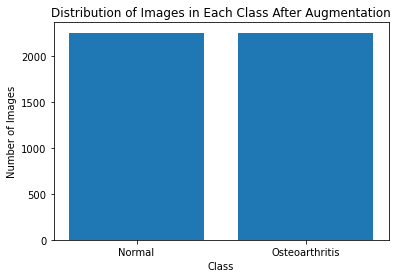

In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define a function to load and resize images from a folder
def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
    return images

# Load images from directories for each class
normal_images = load_and_resize_images_from_folder('/home/lab5/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Normal')
osteoarthritis_images = load_and_resize_images_from_folder('/home/lab5/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Osteoarthritis')

# Display the number of images in each class
print("Number of images in Normal class:", len(normal_images))
print("Number of images in Osteoarthritis class:", len(osteoarthritis_images))

# Check if data augmentation is needed
if len(normal_images) < len(osteoarthritis_images):
    # Calculate the number of additional images needed
    num_additional_images = len(osteoarthritis_images) - len(normal_images)

    # Create an ImageDataGenerator for data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Choose random indices from the "Normal" class for augmentation
    sampled_indices = np.random.randint(0, len(normal_images), size=num_additional_images)

    # Perform data augmentation and append augmented images to the "Normal" class
    for index in sampled_indices:
        img = normal_images[index]
        img = img.reshape((1,) + img.shape)  # Reshape for flow() function
        for batch in datagen.flow(img, batch_size=1):
            normal_images.append(batch[0])  # Append augmented images
            break  # Exit the loop after one iteration of data augmentation

    # Display the number of images in the "Normal" class after augmentation
    print("Number of images in Normal class after augmentation:", len(normal_images))

# Create a histogram to visualize the distribution of images in each class after augmentation
plt.bar(['Normal', 'Osteoarthritis'], [len(normal_images), len(osteoarthritis_images)])
plt.title('Distribution of Images in Each Class After Augmentation')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


In [3]:
import random

# Set a seed for reproducibility
random.seed(42)

# Randomly select 1000 images from each class
selected_normal_images = random.sample(normal_images, 1500)
selected_osteoarthritis_images = random.sample(osteoarthritis_images, 1500)

# Combine selected images from both classes
selected_images = selected_normal_images + selected_osteoarthritis_images
labels = [0] * 1500 + [1] * 1500  # Assign labels (0 for Normal, 1 for Osteoarthritis)

# Split the selected images and labels into train and test sets (70:30 ratio)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(selected_images, labels, test_size=0.3, random_state=42)

# Split the train set into train and validation sets (80:20 ratio)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print the sizes of train, test, and validation sets
print("X_train size:", len(X_train))
print("X_test size:", len(X_test))
print("X_validation size:", len(X_val))


X_train size: 1680
X_test size: 900
X_validation size: 420


In [4]:
import pandas as pd
from sklearn.metrics import balanced_accuracy_score,matthews_corrcoef,cohen_kappa_score

# CNN+Dense

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Preprocess data
X_train = np.array(X_train) / 255.0  # Scale pixel values to [0, 1]
X_val = np.array(X_val) / 255.0
X_test = np.array(X_test) / 255.0

# Define CNN architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

/home/lab5/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 279ms/step - accuracy: 0.5221 - loss: 0.8691 - val_accuracy: 0.4857 - val_loss: 0.6935
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 278ms/step - accuracy: 0.4866 - loss: 0.6922 - val_accuracy: 0.5976 - val_loss: 0.6871
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 281ms/step - accuracy: 0.5570 - loss: 0.6861 - val_accuracy: 0.5929 - val_loss: 0.6775
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 285ms/step - accuracy: 0.5501 - loss: 0.6801 - val_accuracy: 0.5810 - val_loss: 0.6730
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 290ms/step - accuracy: 0.5482 - loss: 0.6723 - val_accuracy: 0.5452 - val_loss: 0.6981
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 290ms/step - accuracy: 0.5471 - loss: 0.6777 - val_accuracy: 0.5952 - val_loss: 0.6599
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 289ms/step - accuracy: 0.5667 - loss: 0.6571 - val_accuracy: 0.6119 - val_loss: 0.6451
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 289ms/step - accuracy: 0.5877 - loss: 0.6437 - val_accu

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step


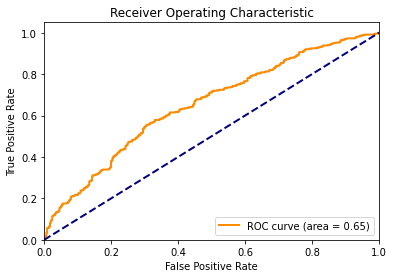

Test Loss (Clipped): 0.679563983136056
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5890 - loss: 0.6511
Validation Loss: 0.6286654472351074
Validation Accuracy: 0.6142857074737549
Test Loss: 0.679563983136056
Inference Time (seconds): 2.6003220081329346
Test Accuracy: 0.6055555555555555
Confusion Matrix:
 [[349 112]
 [243 196]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.76      0.66       461
           1       0.64      0.45      0.52       439

    accuracy                           0.61       900
   macro avg       0.61      0.60      0.59       900
weighted avg       0.61      0.61      0.60       900

ROC AUC Score: 0.6505566288992435
Metrics saved successfully


In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

import numpy as np
from sklearn.metrics import log_loss

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Print test loss
print("Test Loss (Clipped):", test_loss)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
metrics={
    'Combination':'CNN+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('CNN_3000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [8]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 289ms/step - accuracy: 0.6918 - loss: 0.5974 - val_accuracy: 0.6643 - val_loss: 0.6277
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 294ms/step - accuracy: 0.7330 - loss: 0.5434 - val_accuracy: 0.6738 - val_loss: 0.6301
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 293ms/step - accuracy: 0.7157 - loss: 0.5478 - val_accuracy: 0.6000 - val_loss: 0.7373
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 293ms/step - accuracy: 0.7485 - loss: 0.4927 - val_accuracy: 0.6810 - val_loss: 0.6365
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 295ms/step - accuracy: 0.8038 - loss: 0.4178 - val_accuracy: 0.6976 - val_loss: 0.5994
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 295ms/step - accuracy: 0.8383 - loss: 0.3764 - val_accuracy: 0.7000 - val_loss: 0.6772
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 293ms/step - accuracy: 0.8439 - loss: 0.3519 - val_accuracy: 0.6810 - val_loss: 0.7304
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 295ms/step - accuracy: 0.8719 - loss: 0.3000 - 

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step


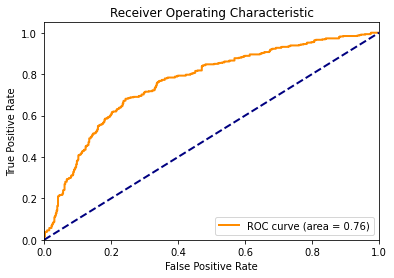

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6899 - loss: 0.6265
Validation Loss: 0.5994444489479065
Validation Accuracy: 0.6976190209388733
Test Loss: 0.6521751637381346
Inference Time (seconds): 2.258157253265381
Test Accuracy: 0.7188888888888889
Confusion Matrix:
 [[348 113]
 [140 299]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.75      0.73       461
           1       0.73      0.68      0.70       439

    accuracy                           0.72       900
   macro avg       0.72      0.72      0.72       900
weighted avg       0.72      0.72      0.72       900

ROC AUC Score: 0.7613882863340564
Metrics saved successfully


In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
metrics={
    'Combination':'CNN+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('CNN_3000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [10]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 296ms/step - accuracy: 0.8268 - loss: 0.3746 - val_accuracy: 0.6405 - val_loss: 0.7609
Epoch 2/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 292ms/step - accuracy: 0.8543 - loss: 0.3290 - val_accuracy: 0.6405 - val_loss: 0.7985
Epoch 3/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 296ms/step - accuracy: 0.8558 - loss: 0.3101 - val_accuracy: 0.7214 - val_loss: 0.6444
Epoch 4/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 294ms/step - accuracy: 0.8942 - loss: 0.2442 - val_accuracy: 0.6929 - val_loss: 0.7442
Epoch 5/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 296ms/step - accuracy: 0.9033 - loss: 0.2096 - val_accuracy: 0.7238 - val_loss: 0.7916
Epoch 6/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 294ms/step - accuracy: 0.9459 - loss: 0.1589 - val_accuracy: 0.7071 - val_loss: 0.8936
Epoch 7/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 294ms/step - accuracy: 0.9619 - loss: 0.1193 - val_accuracy: 0.7286 - val_loss: 0.9002
Epoch 8/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 295ms/step - accuracy: 0.9562 - loss: 0.1173 - 

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


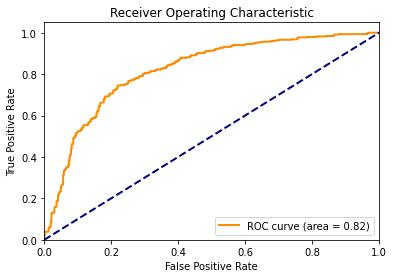

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.7225 - loss: 0.7206
Validation Loss: 0.6443788409233093
Validation Accuracy: 0.7214285731315613
Test Loss: 0.6748644416620603
Inference Time (seconds): 2.232832908630371
Test Accuracy: 0.7522222222222222
Confusion Matrix:
 [[330 131]
 [ 92 347]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.72      0.75       461
           1       0.73      0.79      0.76       439

    accuracy                           0.75       900
   macro avg       0.75      0.75      0.75       900
weighted avg       0.75      0.75      0.75       900

ROC AUC Score: 0.8184940137069558
Metrics saved successfully


In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
metrics={
    'Combination':'CNN+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('CNN_3000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [12]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 292ms/step - accuracy: 0.9180 - loss: 0.2142 - val_accuracy: 0.6833 - val_loss: 0.7498
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 289ms/step - accuracy: 0.8983 - loss: 0.2232 - val_accuracy: 0.6929 - val_loss: 0.7822
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 290ms/step - accuracy: 0.9130 - loss: 0.1940 - val_accuracy: 0.7095 - val_loss: 0.9216
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 288ms/step - accuracy: 0.9521 - loss: 0.1268 - val_accuracy: 0.7119 - val_loss: 0.9279
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 288ms/step - accuracy: 0.9747 - loss: 0.0864 - val_accuracy: 0.7286 - val_loss: 1.0274
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 288ms/step - accuracy: 0.9803 - loss: 0.0574 - val_accuracy: 0.7571 - val_loss: 1.0585
Training Time: 92.65780901908875 seconds


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


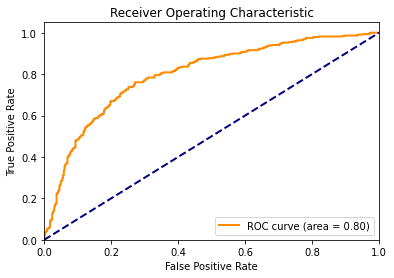

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6656 - loss: 0.8088
Validation Loss: 0.749750554561615
Validation Accuracy: 0.6833333373069763
Test Loss: 0.745461768984863
Inference Time (seconds): 2.2270095348358154
Test Accuracy: 0.7422222222222222
Confusion Matrix:
 [[344 117]
 [115 324]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75       461
           1       0.73      0.74      0.74       439

    accuracy                           0.74       900
   macro avg       0.74      0.74      0.74       900
weighted avg       0.74      0.74      0.74       900

ROC AUC Score: 0.7973233388839751
Metrics saved successfully


In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
metrics={
    'Combination':'CNN+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('CNN_3000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")


# CNN+Dropout+Dense

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define CNN architecture for RGB images
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # Change input shape to (224, 224, 3)
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])


# Compile the model with Adam optimizer and additional metrics
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,396,609 (169.36 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 452ms/step - accuracy: 0.4868 - loss: 1.3122 - val_accuracy: 0.5690 - val_loss: 0.6910
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 447ms/step - accuracy: 0.5250 - loss: 0.6949 - val_accuracy: 0.5333 - val_loss: 0.6912
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 452ms/step - accuracy: 0.5047 - loss: 0.6934 - val_accuracy: 0.5333 - val_loss: 0.6907
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 453ms/step - accuracy: 0.5155 - loss: 0.6916 - val_accuracy: 0.6143 - val_loss: 0.6746
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 453ms/step - accuracy: 0.5509 - loss: 0.6851 - val_accuracy: 0.5714 - val_loss: 0.6682
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 452ms/step - accuracy: 0.5609 - loss: 0.6763 - val_accuracy: 0.5881 - val_loss: 0.6632
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 453ms/step - accuracy: 0.5605 - loss: 0.6773 - val_accuracy: 0.5833 - val_loss: 0.6608
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 454ms/step - accuracy: 0.5262 - loss: 0.6762 - val_accu

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step


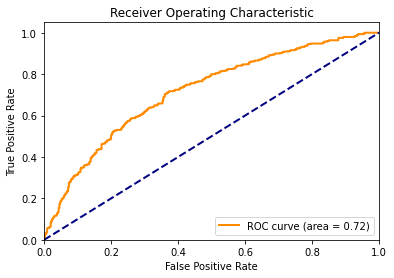

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6883 - loss: 0.6364
Validation Loss: 0.6254242062568665
Validation Accuracy: 0.699999988079071
Test Loss: 0.6714584522703739
Inference Time (seconds): 2.4944963455200195
Test Accuracy: 0.6577777777777778
Confusion Matrix:
 [[305 156]
 [152 287]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.66      0.66       461
           1       0.65      0.65      0.65       439

    accuracy                           0.66       900
   macro avg       0.66      0.66      0.66       900
weighted avg       0.66      0.66      0.66       900

ROC AUC Score: 0.7155930210150263
Metrics saved successfully


In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_3000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_3000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [9]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 455ms/step - accuracy: 0.7714 - loss: 0.4502 - val_accuracy: 0.7262 - val_loss: 0.6724
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 452ms/step - accuracy: 0.8204 - loss: 0.3703 - val_accuracy: 0.7024 - val_loss: 0.7532
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 453ms/step - accuracy: 0.8405 - loss: 0.3564 - val_accuracy: 0.7310 - val_loss: 0.7074
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 452ms/step - accuracy: 0.8771 - loss: 0.2854 - val_accuracy: 0.7143 - val_loss: 0.8441
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 452ms/step - accuracy: 0.9045 - loss: 0.2418 - val_accuracy: 0.7571 - val_loss: 0.8333
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 453ms/step - accuracy: 0.9261 - loss: 0.1788 - val_accuracy: 0.7310 - val_loss: 0.9323
Training Time: 144.5043716430664 seconds


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


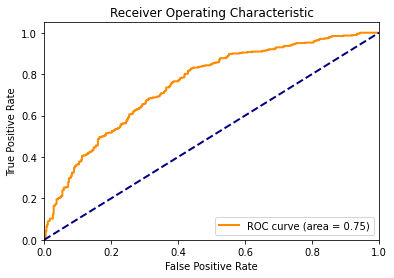

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7059 - loss: 0.7005
Validation Loss: 0.6724366545677185
Validation Accuracy: 0.726190447807312
Test Loss: 0.6677412619578066
Inference Time (seconds): 2.3772025108337402
Test Accuracy: 0.6777777777777778
Confusion Matrix:
 [[308 153]
 [137 302]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.67      0.68       461
           1       0.66      0.69      0.68       439

    accuracy                           0.68       900
   macro avg       0.68      0.68      0.68       900
weighted avg       0.68      0.68      0.68       900

ROC AUC Score: 0.7489512251765252
Metrics saved successfully


In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_3000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_3000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [11]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 454ms/step - accuracy: 0.8235 - loss: 0.3694 - val_accuracy: 0.7024 - val_loss: 0.6929
Epoch 2/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 452ms/step - accuracy: 0.8359 - loss: 0.3506 - val_accuracy: 0.7095 - val_loss: 0.7634
Epoch 3/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 453ms/step - accuracy: 0.8588 - loss: 0.3095 - val_accuracy: 0.7429 - val_loss: 0.6808
Epoch 4/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 455ms/step - accuracy: 0.9050 - loss: 0.2451 - val_accuracy: 0.7048 - val_loss: 0.8380
Epoch 5/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 454ms/step - accuracy: 0.9294 - loss: 0.1861 - val_accuracy: 0.7571 - val_loss: 0.7980
Epoch 6/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 453ms/step - accuracy: 0.9267 - loss: 0.1844 - val_accuracy: 0.7429 - val_loss: 0.8967
Epoch 7/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 451ms/step - accuracy: 0.9519 - loss: 0.1411 - val_accuracy: 0.7619 - val_loss: 0.8954
Epoch 8/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 453ms/step - accuracy: 0.9627 - loss: 0.1033 - 

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


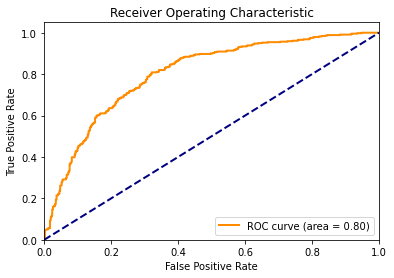

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.7281 - loss: 0.6731
Validation Loss: 0.6808089017868042
Validation Accuracy: 0.7428571581840515
Test Loss: 0.6611236884535033
Inference Time (seconds): 2.3810555934906006
Test Accuracy: 0.7277777777777777
Confusion Matrix:
 [[336 125]
 [120 319]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.73      0.73       461
           1       0.72      0.73      0.72       439

    accuracy                           0.73       900
   macro avg       0.73      0.73      0.73       900
weighted avg       0.73      0.73      0.73       900

ROC AUC Score: 0.801881618152081
Metrics saved successfully


In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val,y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_3000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_3000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [13]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 459ms/step - accuracy: 0.9243 - loss: 0.2104 - val_accuracy: 0.7429 - val_loss: 0.7537
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 452ms/step - accuracy: 0.9278 - loss: 0.1887 - val_accuracy: 0.7262 - val_loss: 0.8293
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 452ms/step - accuracy: 0.9320 - loss: 0.1870 - val_accuracy: 0.7476 - val_loss: 0.8694
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 452ms/step - accuracy: 0.9475 - loss: 0.1308 - val_accuracy: 0.7833 - val_loss: 0.8924
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 454ms/step - accuracy: 0.9543 - loss: 0.1141 - val_accuracy: 0.7381 - val_loss: 1.1486
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 453ms/step - accuracy: 0.9501 - loss: 0.1229 - val_accuracy: 0.7595 - val_loss: 1.0061
Training Time: 144.71292400360107 seconds


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


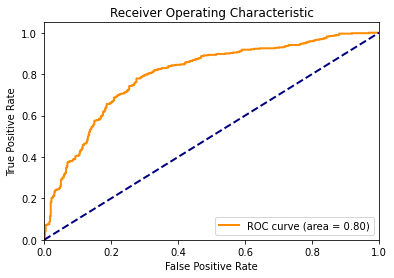

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.7349 - loss: 0.7656
Validation Loss: 0.7536631226539612
Validation Accuracy: 0.7428571581840515
Test Loss: 0.71262296349102
Inference Time (seconds): 2.378941059112549
Test Accuracy: 0.7422222222222222
Confusion Matrix:
 [[344 117]
 [115 324]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75       461
           1       0.73      0.74      0.74       439

    accuracy                           0.74       900
   macro avg       0.74      0.74      0.74       900
weighted avg       0.74      0.74      0.74       900

ROC AUC Score: 0.7979162857806392
Metrics saved successfully


In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_3000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_3000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+GlobbalAveragePooling+Dense

In [15]:
from tensorflow.keras.layers import GlobalAveragePooling2D
#Define custom CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    GlobalAveragePooling2D(),  # Global Average Pooling layer
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer and additional metrics
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/home/lab5/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,809 (624.25 KB)

 Trainable params: 159,809 (624.25 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 232ms/step - accuracy: 0.5093 - loss: 0.6942 - val_accuracy: 0.5143 - val_loss: 0.6925
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 223ms/step - accuracy: 0.5151 - loss: 0.6951 - val_accuracy: 0.5214 - val_loss: 0.6930
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 235ms/step - accuracy: 0.5051 - loss: 0.6933 - val_accuracy: 0.4857 - val_loss: 0.6929
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 237ms/step - accuracy: 0.4803 - loss: 0.6922 - val_accuracy: 0.5452 - val_loss: 0.6913
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 237ms/step - accuracy: 0.5216 - loss: 0.6918 - val_accuracy: 0.5333 - val_loss: 0.6905
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 237ms/step - accuracy: 0.5125 - loss: 0.6931 - val_accuracy: 0.5429 - val_loss: 0.6908
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 238ms/step - accuracy: 0.4995 - loss: 0.6925 - val_accuracy: 0.5500 - val_loss: 0.6903
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 243ms/step - accuracy: 0.5315 - loss: 0.6893 - val_accu

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step


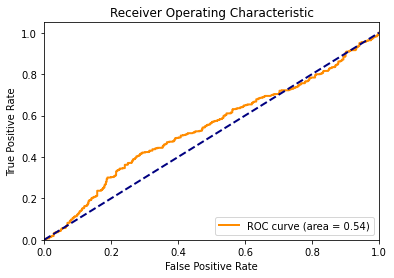

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.5638 - loss: 0.6902
Validation Loss: 0.68968665599823
Validation Accuracy: 0.550000011920929
Test Loss: 0.6892164667447408
Inference Time (seconds): 2.208970785140991
Test Accuracy: 0.5611111111111111
Confusion Matrix:
 [[346 115]
 [280 159]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.75      0.64       461
           1       0.58      0.36      0.45       439

    accuracy                           0.56       900
   macro avg       0.57      0.56      0.54       900
weighted avg       0.57      0.56      0.54       900

ROC AUC Score: 0.5410541607577861
Metrics saved successfully


In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_3000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+GlobbalAveragePooling+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_3000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [18]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 247ms/step - accuracy: 0.5283 - loss: 0.6917 - val_accuracy: 0.5619 - val_loss: 0.6902
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 245ms/step - accuracy: 0.5267 - loss: 0.6903 - val_accuracy: 0.5405 - val_loss: 0.6911
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 246ms/step - accuracy: 0.4960 - loss: 0.6925 - val_accuracy: 0.5476 - val_loss: 0.6905
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 249ms/step - accuracy: 0.5200 - loss: 0.6897 - val_accuracy: 0.5643 - val_loss: 0.6887
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 248ms/step - accuracy: 0.5299 - loss: 0.6885 - val_accuracy: 0.4833 - val_loss: 0.6939
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 245ms/step - accuracy: 0.5331 - loss: 0.6882 - val_accuracy: 0.5667 - val_loss: 0.6880
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 246ms/step - accuracy: 0.5412 - loss: 0.6901 - val_accuracy: 0.5500 - val_loss: 0.6893
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 246ms/step - accuracy: 0.5081 - loss: 0.6984 - 

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


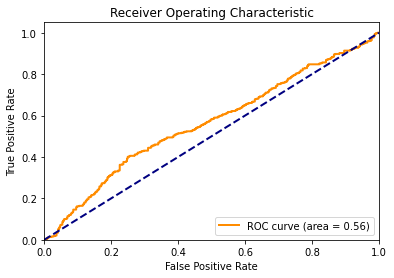

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.5718 - loss: 0.6898
Validation Loss: 0.68804931640625
Validation Accuracy: 0.5666666626930237
Test Loss: 0.6871464586257935
Inference Time (seconds): 2.152635097503662
Test Accuracy: 0.5722222222222222
Confusion Matrix:
 [[333 128]
 [257 182]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.72      0.63       461
           1       0.59      0.41      0.49       439

    accuracy                           0.57       900
   macro avg       0.58      0.57      0.56       900
weighted avg       0.58      0.57      0.56       900

ROC AUC Score: 0.5622174237445585
Metrics saved successfully


In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_3000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+GlobbalAveragePooling+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_3000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [20]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 246ms/step - accuracy: 0.5137 - loss: 0.6907 - val_accuracy: 0.5524 - val_loss: 0.6880
Epoch 2/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 244ms/step - accuracy: 0.5401 - loss: 0.6898 - val_accuracy: 0.5571 - val_loss: 0.6886
Epoch 3/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 245ms/step - accuracy: 0.5312 - loss: 0.6887 - val_accuracy: 0.5548 - val_loss: 0.6890
Epoch 4/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 244ms/step - accuracy: 0.5361 - loss: 0.6890 - val_accuracy: 0.5595 - val_loss: 0.6867
Epoch 5/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 245ms/step - accuracy: 0.5295 - loss: 0.6923 - val_accuracy: 0.5405 - val_loss: 0.6889
Epoch 6/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 245ms/step - accuracy: 0.5201 - loss: 0.6912 - val_accuracy: 0.5619 - val_loss: 0.6865
Epoch 7/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 245ms/step - accuracy: 0.5631 - loss: 0.6866 - val_accuracy: 0.5405 - val_loss: 0.6870
Epoch 8/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 245ms/step - accuracy: 0.5388 - loss: 0.6893 - 

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


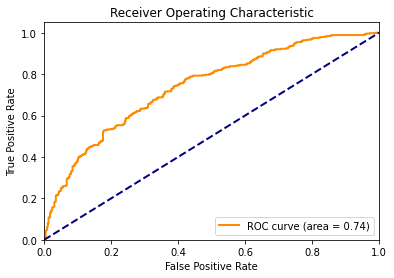

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6210 - loss: 0.6411
Validation Loss: 0.6059039831161499
Validation Accuracy: 0.6666666865348816
Test Loss: 0.6053496587235067
Inference Time (seconds): 2.159414529800415
Test Accuracy: 0.6722222222222223
Confusion Matrix:
 [[290 171]
 [124 315]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.63      0.66       461
           1       0.65      0.72      0.68       439

    accuracy                           0.67       900
   macro avg       0.67      0.67      0.67       900
weighted avg       0.67      0.67      0.67       900

ROC AUC Score: 0.7391231303643165
Metrics saved successfully


In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_3000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+GlobbalAveragePooling+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_3000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [22]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 246ms/step - accuracy: 0.6697 - loss: 0.6108 - val_accuracy: 0.6286 - val_loss: 0.6222
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 246ms/step - accuracy: 0.6572 - loss: 0.6138 - val_accuracy: 0.6524 - val_loss: 0.6100
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 245ms/step - accuracy: 0.6849 - loss: 0.5997 - val_accuracy: 0.6310 - val_loss: 0.6286
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 245ms/step - accuracy: 0.6600 - loss: 0.6227 - val_accuracy: 0.6738 - val_loss: 0.6074
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 245ms/step - accuracy: 0.6629 - loss: 0.6028 - val_accuracy: 0.6524 - val_loss: 0.6101
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 245ms/step - accuracy: 0.6763 - loss: 0.5974 - val_accuracy: 0.6714 - val_loss: 0.6013
Epoch 7/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 244ms/step - accuracy: 0.6942 - loss: 0.6004 - val_accuracy: 0.6524 - val_loss: 0.6066
Epoch 8/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 246ms/step - accuracy: 0.6521 - loss: 0.6063 - 

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


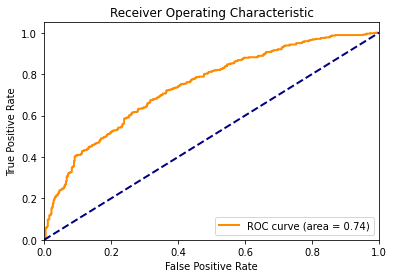

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6393 - loss: 0.6358
Validation Loss: 0.6013075709342957
Validation Accuracy: 0.6714285612106323
Test Loss: 0.6024773068891631
Inference Time (seconds): 2.167952299118042
Test Accuracy: 0.6755555555555556
Confusion Matrix:
 [[298 163]
 [129 310]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.65      0.67       461
           1       0.66      0.71      0.68       439

    accuracy                           0.68       900
   macro avg       0.68      0.68      0.68       900
weighted avg       0.68      0.68      0.68       900

ROC AUC Score: 0.7410798551233082
Metrics saved successfully


In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_3000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+GlobbalAveragePooling+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_3000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+Conv2D+GlobalAveragePooling+Dropout+Dense

In [24]:
# Define custom CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    GlobalAveragePooling2D(),  # Global Average Pooling layer
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/home/lab5/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 220, 220, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 108, 108, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,809 (624.25 KB)

 Trainable params: 159,809 (624.25 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 44s 813ms/step - accuracy: 0.5033 - loss: 0.6956 - val_accuracy: 0.4857 - val_loss: 0.6955
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 44s 821ms/step - accuracy: 0.5148 - loss: 0.6932 - val_accuracy: 0.5190 - val_loss: 0.6923
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 844ms/step - accuracy: 0.5201 - loss: 0.6934 - val_accuracy: 0.4857 - val_loss: 0.6920
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 850ms/step - accuracy: 0.5064 - loss: 0.6914 - val_accuracy: 0.5667 - val_loss: 0.6904
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 844ms/step - accuracy: 0.5250 - loss: 0.6908 - val_accuracy: 0.5643 - val_loss: 0.6903
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 855ms/step - accuracy: 0.5262 - loss: 0.6914 - val_accuracy: 0.4952 - val_loss: 0.6918
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 848ms/step - accuracy: 0.5400 - loss: 0.6942 - val_accuracy: 0.5857 - val_loss: 0.6900
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 849ms/step - accuracy: 0.5088 - loss: 0.6913 - val_accu

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step


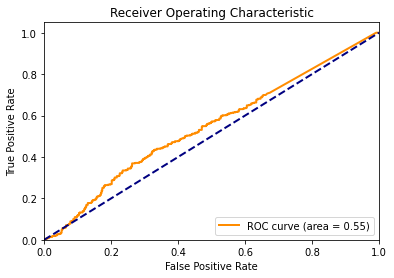

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.5652 - loss: 0.6898
Validation Loss: 0.689052402973175
Validation Accuracy: 0.561904788017273
Test Loss: 0.6906404336955813
Inference Time (seconds): 5.382826566696167
Test Accuracy: 0.5555555555555556
Confusion Matrix:
 [[340 121]
 [279 160]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.74      0.63       461
           1       0.57      0.36      0.44       439

    accuracy                           0.56       900
   macro avg       0.56      0.55      0.54       900
weighted avg       0.56      0.56      0.54       900

ROC AUC Score: 0.5452566718878935
Metrics saved successfully


In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_3000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_3000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [27]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 848ms/step - accuracy: 0.5098 - loss: 0.6923 - val_accuracy: 0.5476 - val_loss: 0.6897
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 854ms/step - accuracy: 0.5291 - loss: 0.6926 - val_accuracy: 0.5452 - val_loss: 0.6893
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 854ms/step - accuracy: 0.5495 - loss: 0.6904 - val_accuracy: 0.5476 - val_loss: 0.6892
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 854ms/step - accuracy: 0.5211 - loss: 0.6885 - val_accuracy: 0.5524 - val_loss: 0.6888
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 46s 859ms/step - accuracy: 0.5212 - loss: 0.6919 - val_accuracy: 0.5690 - val_loss: 0.6890
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 852ms/step - accuracy: 0.5212 - loss: 0.6910 - val_accuracy: 0.5643 - val_loss: 0.6887
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 855ms/step - accuracy: 0.5293 - loss: 0.6895 - val_accuracy: 0.5714 - val_loss: 0.6882
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 46s 865ms/step - accuracy: 0.5309 - loss: 0.6925 - 

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step


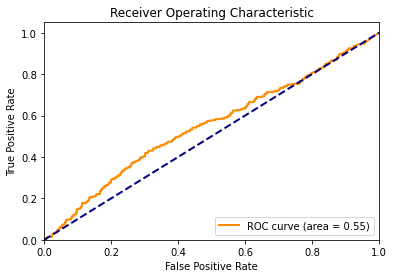

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.5689 - loss: 0.6897
Validation Loss: 0.6881940960884094
Validation Accuracy: 0.5714285969734192
Test Loss: 0.6897831609514025
Inference Time (seconds): 5.417479515075684
Test Accuracy: 0.5588888888888889
Confusion Matrix:
 [[322 139]
 [258 181]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.70      0.62       461
           1       0.57      0.41      0.48       439

    accuracy                           0.56       900
   macro avg       0.56      0.56      0.55       900
weighted avg       0.56      0.56      0.55       900

ROC AUC Score: 0.5479397565952989
Metrics saved successfully


In [28]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_3000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_3000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [29]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 853ms/step - accuracy: 0.5271 - loss: 0.6897 - val_accuracy: 0.5667 - val_loss: 0.6882
Epoch 2/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 46s 860ms/step - accuracy: 0.5313 - loss: 0.6904 - val_accuracy: 0.5357 - val_loss: 0.6880
Epoch 3/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 46s 863ms/step - accuracy: 0.5162 - loss: 0.6912 - val_accuracy: 0.5405 - val_loss: 0.6880
Epoch 4/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 843ms/step - accuracy: 0.5146 - loss: 0.6907 - val_accuracy: 0.5548 - val_loss: 0.6878
Epoch 5/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 849ms/step - accuracy: 0.5415 - loss: 0.6894 - val_accuracy: 0.5690 - val_loss: 0.6869
Epoch 6/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 851ms/step - accuracy: 0.5509 - loss: 0.6889 - val_accuracy: 0.5643 - val_loss: 0.6851
Epoch 7/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 855ms/step - accuracy: 0.5282 - loss: 0.6889 - val_accuracy: 0.5571 - val_loss: 0.6835
Epoch 8/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 844ms/step - accuracy: 0.5150 - loss: 0.6879 - 

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step


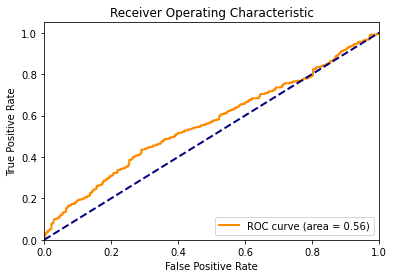

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.5657 - loss: 0.6844
Validation Loss: 0.6747660040855408
Validation Accuracy: 0.5666666626930237
Test Loss: 0.6821800510916445
Inference Time (seconds): 5.335355997085571
Test Accuracy: 0.5666666666666667
Confusion Matrix:
 [[328 133]
 [257 182]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.71      0.63       461
           1       0.58      0.41      0.48       439

    accuracy                           0.57       900
   macro avg       0.57      0.56      0.55       900
weighted avg       0.57      0.57      0.56       900

ROC AUC Score: 0.5643026203311607
Metrics saved successfully


In [30]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_3000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_3000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [31]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 850ms/step - accuracy: 0.5393 - loss: 0.6810 - val_accuracy: 0.5643 - val_loss: 0.6743
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 848ms/step - accuracy: 0.5517 - loss: 0.7022 - val_accuracy: 0.5452 - val_loss: 0.6879
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 859ms/step - accuracy: 0.5188 - loss: 0.6910 - val_accuracy: 0.5476 - val_loss: 0.6843
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 849ms/step - accuracy: 0.5230 - loss: 0.6846 - val_accuracy: 0.5548 - val_loss: 0.6823
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 855ms/step - accuracy: 0.5396 - loss: 0.6822 - val_accuracy: 0.5548 - val_loss: 0.6829
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 852ms/step - accuracy: 0.5499 - loss: 0.6850 - val_accuracy: 0.5619 - val_loss: 0.6802
Training Time: 271.2882273197174 seconds


29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step


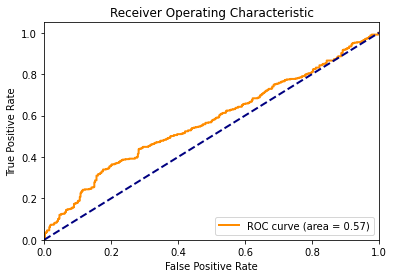

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.5704 - loss: 0.6839
Validation Loss: 0.6743047833442688
Validation Accuracy: 0.5642856955528259
Test Loss: 0.6796982832252979
Inference Time (seconds): 5.372029781341553
Test Accuracy: 0.5666666666666667
Confusion Matrix:
 [[338 123]
 [267 172]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.73      0.63       461
           1       0.58      0.39      0.47       439

    accuracy                           0.57       900
   macro avg       0.57      0.56      0.55       900
weighted avg       0.57      0.57      0.55       900

ROC AUC Score: 0.573068351953513
Metrics saved successfully


In [32]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_3000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_3000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+LSTM+Dense

In [33]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Reshape, LSTM, Dense
from tensorflow.keras.models import Model

# Define the input shape
input_shape = (224, 224, 3)

# Define the CNN base model
input_layer = Input(shape=input_shape)
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_layer)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
flatten = Flatten()(pool2)

# Define the LSTM layer
reshape = Reshape((1, -1))(flatten)
lstm = LSTM(128)(reshape)

# Define the dense layers for classification
dense1 = Dense(64, activation='relu')(lstm)
output_layer = Dense(1, activation='sigmoid')(dense1)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 186624)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │    95,617,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,645,249 (364.86 MB)

 Trainable params: 95,645,249 (364.86 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 735ms/step - accuracy: 0.5027 - loss: 0.6979 - val_accuracy: 0.4857 - val_loss: 0.6935
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 728ms/step - accuracy: 0.4908 - loss: 0.6950 - val_accuracy: 0.4857 - val_loss: 0.6971
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 727ms/step - accuracy: 0.5066 - loss: 0.6941 - val_accuracy: 0.5143 - val_loss: 0.6957
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 729ms/step - accuracy: 0.4645 - loss: 0.7060 - val_accuracy: 0.5143 - val_loss: 0.6928
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 726ms/step - accuracy: 0.4848 - loss: 0.6980 - val_accuracy: 0.5143 - val_loss: 0.6930
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 726ms/step - accuracy: 0.4791 - loss: 0.6986 - val_accuracy: 0.5143 - val_loss: 0.6952
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 728ms/step - accuracy: 0.5113 - loss: 0.6937 - val_accuracy: 0.4857 - val_loss: 0.6941
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 727ms/step - accuracy: 0.4852 - loss: 0.6953 - val_accu

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


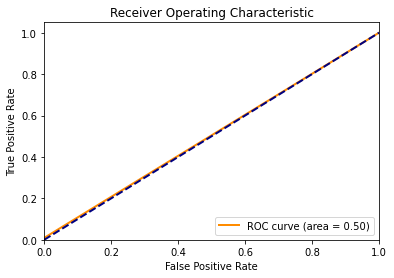

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5236 - loss: 0.6923
Validation Loss: 0.6927911639213562
Validation Accuracy: 0.5142857432365417
Test Loss: 0.6928483692142698
Inference Time (seconds): 2.343994379043579
Test Accuracy: 0.5122222222222222
Confusion Matrix:
 [[461   0]
 [439   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.51      1.00      0.68       461
           1       0.00      0.00      0.00       439

    accuracy                           0.51       900
   macro avg       0.26      0.50      0.34       900
weighted avg       0.26      0.51      0.35       900

ROC AUC Score: 0.5046175739577723
Metrics saved successfully


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in scalar divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [35]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_3000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_3000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [36]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 733ms/step - accuracy: 0.4968 - loss: 0.6955 - val_accuracy: 0.4857 - val_loss: 0.7031
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 728ms/step - accuracy: 0.5384 - loss: 0.6912 - val_accuracy: 0.5143 - val_loss: 0.6928
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 728ms/step - accuracy: 0.4965 - loss: 0.6957 - val_accuracy: 0.4857 - val_loss: 0.6971
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 726ms/step - accuracy: 0.5273 - loss: 0.6928 - val_accuracy: 0.5143 - val_loss: 0.6929
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 728ms/step - accuracy: 0.4956 - loss: 0.6952 - val_accuracy: 0.4857 - val_loss: 0.6982
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 728ms/step - accuracy: 0.4988 - loss: 0.6993 - val_accuracy: 0.4857 - val_loss: 0.6956
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 727ms/step - accuracy: 0.5011 - loss: 0.6951 - val_accuracy: 0.4857 - val_loss: 0.6957
Training Time: 270.77013874053955 seconds


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


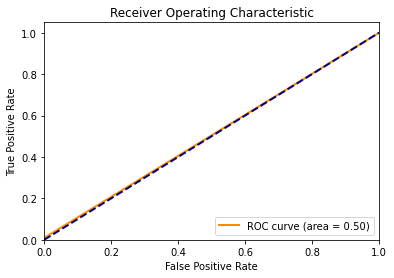

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5236 - loss: 0.6922
Validation Loss: 0.6928029656410217
Validation Accuracy: 0.5142857432365417
Test Loss: 0.6928784822755389
Inference Time (seconds): 2.2327017784118652
Test Accuracy: 0.5122222222222222
Confusion Matrix:
 [[461   0]
 [439   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.51      1.00      0.68       461
           1       0.00      0.00      0.00       439

    accuracy                           0.51       900
   macro avg       0.26      0.50      0.34       900
weighted avg       0.26      0.51      0.35       900

ROC AUC Score: 0.5043631009146207
Metrics saved successfully


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in scalar divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [37]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_3000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_3000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [38]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 729ms/step - accuracy: 0.5010 - loss: 0.6959 - val_accuracy: 0.5143 - val_loss: 0.7046
Epoch 2/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 729ms/step - accuracy: 0.5244 - loss: 0.6943 - val_accuracy: 0.5143 - val_loss: 0.6928
Epoch 3/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 727ms/step - accuracy: 0.4886 - loss: 0.6948 - val_accuracy: 0.4857 - val_loss: 0.6951
Epoch 4/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 733ms/step - accuracy: 0.5171 - loss: 0.6955 - val_accuracy: 0.5143 - val_loss: 0.6928
Epoch 5/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 729ms/step - accuracy: 0.4933 - loss: 0.6988 - val_accuracy: 0.4857 - val_loss: 0.6999
Epoch 6/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 729ms/step - accuracy: 0.4995 - loss: 0.6958 - val_accuracy: 0.4857 - val_loss: 0.6980
Epoch 7/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 727ms/step - accuracy: 0.5005 - loss: 0.6953 - val_accuracy: 0.4857 - val_loss: 0.7020
Training Time: 271.0052185058594 seconds


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


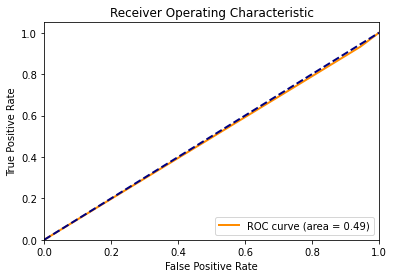

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5236 - loss: 0.6922
Validation Loss: 0.6927981972694397
Validation Accuracy: 0.5142857432365417
Test Loss: 0.6928714676698049
Inference Time (seconds): 2.227069854736328
Test Accuracy: 0.5122222222222222
Confusion Matrix:
 [[461   0]
 [439   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.51      1.00      0.68       461
           1       0.00      0.00      0.00       439

    accuracy                           0.51       900
   macro avg       0.26      0.50      0.34       900
weighted avg       0.26      0.51      0.35       900

ROC AUC Score: 0.49403100124024724
Metrics saved successfully


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in scalar divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [39]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_3000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_3000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [40]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 730ms/step - accuracy: 0.5364 - loss: 0.6926 - val_accuracy: 0.5143 - val_loss: 0.6933
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 728ms/step - accuracy: 0.4791 - loss: 0.6956 - val_accuracy: 0.4857 - val_loss: 0.6999
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 728ms/step - accuracy: 0.5151 - loss: 0.6959 - val_accuracy: 0.4857 - val_loss: 0.7008
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 728ms/step - accuracy: 0.4832 - loss: 0.7005 - val_accuracy: 0.4857 - val_loss: 0.6974
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 732ms/step - accuracy: 0.4915 - loss: 0.6946 - val_accuracy: 0.4857 - val_loss: 0.6937
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 727ms/step - accuracy: 0.4807 - loss: 0.6953 - val_accuracy: 0.4857 - val_loss: 0.6988
Training Time: 232.3035306930542 seconds


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


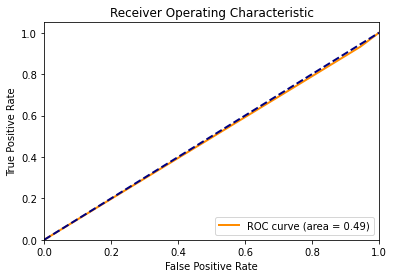

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5236 - loss: 0.6921
Validation Loss: 0.6932902336120605
Validation Accuracy: 0.5142857432365417
Test Loss: 0.6934271968073316
Inference Time (seconds): 2.2151589393615723
Test Accuracy: 0.5122222222222222
Confusion Matrix:
 [[461   0]
 [439   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.51      1.00      0.68       461
           1       0.00      0.00      0.00       439

    accuracy                           0.51       900
   macro avg       0.26      0.50      0.34       900
weighted avg       0.26      0.51      0.35       900

ROC AUC Score: 0.49403100124024724
Metrics saved successfully


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in scalar divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [41]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_3000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_3000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+GRU+Dense

In [42]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Reshape, GRU, Dense
from tensorflow.keras.models import Sequential

# Create the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # Convolutional layer with 32 filters and 3x3 kernel
    MaxPooling2D((2, 2)),  # Max pooling layer with 2x2 pool size
    Conv2D(64, (3, 3), activation='relu'),  # Convolutional layer with 64 filters and 3x3 kernel
    MaxPooling2D((2, 2)),  # Max pooling layer with 2x2 pool size
    Conv2D(128, (3, 3), activation='relu'),  # Convolutional layer with 128 filters and 3x3 kernel
    MaxPooling2D((2, 2)),  # Max pooling layer with 2x2 pool size
    Conv2D(256, (3, 3), activation='relu'),  # Convolutional layer with 256 filters and 3x3 kernel
    MaxPooling2D((2, 2)),  # Max pooling layer with 2x2 pool size
    Flatten(),  # Flatten layer to flatten the output of the convolutional layers
    Reshape((1, -1)),  # Reshape to 3D tensor for GRU
    GRU(128),  # GRU layer with 128 units
    Dense(1, activation='sigmoid')  # Dense layer for binary classification
])

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/home/lab5/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 36864)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │    14,205,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,594,241 (55.67 MB)

 Trainable params: 14,594,241 (55.67 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 328ms/step - accuracy: 0.5091 - loss: 0.8023 - val_accuracy: 0.4857 - val_loss: 0.6980
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 330ms/step - accuracy: 0.5085 - loss: 0.6944 - val_accuracy: 0.4857 - val_loss: 0.6949
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 335ms/step - accuracy: 0.4900 - loss: 0.6956 - val_accuracy: 0.4857 - val_loss: 0.6935
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 334ms/step - accuracy: 0.5028 - loss: 0.6928 - val_accuracy: 0.4881 - val_loss: 0.6814
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 336ms/step - accuracy: 0.5337 - loss: 0.6875 - val_accuracy: 0.5643 - val_loss: 0.6787
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 345ms/step - accuracy: 0.5456 - loss: 0.6838 - val_accuracy: 0.5833 - val_loss: 0.6850
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 349ms/step - accuracy: 0.5569 - loss: 0.6865 - val_accuracy: 0.5667 - val_loss: 0.6764
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 347ms/step - accuracy: 0.5456 - loss: 0.6801 - val_accu

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step


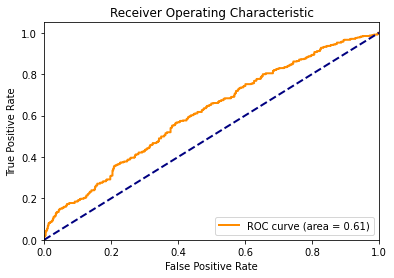

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5723 - loss: 0.6766
Validation Loss: 0.6698299050331116
Validation Accuracy: 0.5880952477455139
Test Loss: 0.6774191275570127
Inference Time (seconds): 2.9012081623077393
Test Accuracy: 0.5566666666666666
Confusion Matrix:
 [[375  86]
 [313 126]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.81      0.65       461
           1       0.59      0.29      0.39       439

    accuracy                           0.56       900
   macro avg       0.57      0.55      0.52       900
weighted avg       0.57      0.56      0.52       900

ROC AUC Score: 0.6114913108573518
Metrics saved successfully


In [44]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_3000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_3000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [45]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 349ms/step - accuracy: 0.5496 - loss: 0.6827 - val_accuracy: 0.5881 - val_loss: 0.6503
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 348ms/step - accuracy: 0.5548 - loss: 0.6807 - val_accuracy: 0.4929 - val_loss: 0.6879
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 347ms/step - accuracy: 0.5477 - loss: 0.6769 - val_accuracy: 0.5595 - val_loss: 0.6678
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 348ms/step - accuracy: 0.5506 - loss: 0.6980 - val_accuracy: 0.4857 - val_loss: 0.6941
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 347ms/step - accuracy: 0.4997 - loss: 0.6931 - val_accuracy: 0.4857 - val_loss: 0.6945
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 347ms/step - accuracy: 0.5020 - loss: 0.6936 - val_accuracy: 0.4857 - val_loss: 0.6941
Training Time: 111.00952482223511 seconds


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step


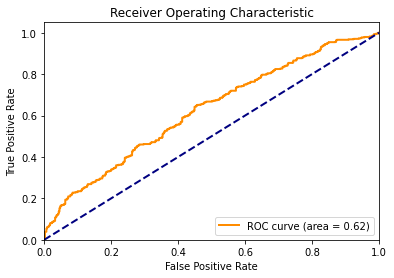

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.5854 - loss: 0.6656
Validation Loss: 0.6502646207809448
Validation Accuracy: 0.5880952477455139
Test Loss: 0.6708405315017121
Inference Time (seconds): 2.6146984100341797
Test Accuracy: 0.5733333333333334
Confusion Matrix:
 [[352 109]
 [275 164]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.76      0.65       461
           1       0.60      0.37      0.46       439

    accuracy                           0.57       900
   macro avg       0.58      0.57      0.55       900
weighted avg       0.58      0.57      0.56       900

ROC AUC Score: 0.623740605497606
Metrics saved successfully


In [46]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_3000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_3000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [47]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 348ms/step - accuracy: 0.5800 - loss: 0.6617 - val_accuracy: 0.5881 - val_loss: 0.6495
Epoch 2/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 348ms/step - accuracy: 0.5530 - loss: 0.6684 - val_accuracy: 0.5905 - val_loss: 0.6539
Epoch 3/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 347ms/step - accuracy: 0.5821 - loss: 0.6586 - val_accuracy: 0.4857 - val_loss: 0.6942
Epoch 4/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 346ms/step - accuracy: 0.5120 - loss: 0.6930 - val_accuracy: 0.4857 - val_loss: 0.6943
Epoch 5/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 346ms/step - accuracy: 0.5099 - loss: 0.6930 - val_accuracy: 0.4857 - val_loss: 0.6938
Epoch 6/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 346ms/step - accuracy: 0.5163 - loss: 0.6928 - val_accuracy: 0.4857 - val_loss: 0.6940
Training Time: 110.6903944015503 seconds


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step


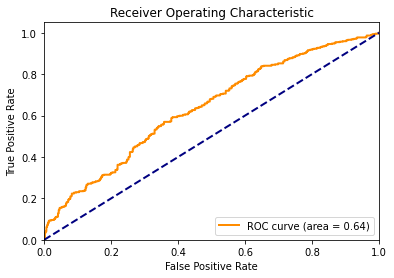

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5864 - loss: 0.6652
Validation Loss: 0.6495296359062195
Validation Accuracy: 0.5880952477455139
Test Loss: 0.6702358097427835
Inference Time (seconds): 2.593468427658081
Test Accuracy: 0.5777777777777777
Confusion Matrix:
 [[344 117]
 [263 176]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.75      0.64       461
           1       0.60      0.40      0.48       439

    accuracy                           0.58       900
   macro avg       0.58      0.57      0.56       900
weighted avg       0.58      0.58      0.56       900

ROC AUC Score: 0.635476012827418
Metrics saved successfully


In [48]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_3000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_3000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [49]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 349ms/step - accuracy: 0.5585 - loss: 0.6532 - val_accuracy: 0.5143 - val_loss: 0.6903
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 347ms/step - accuracy: 0.4797 - loss: 0.6955 - val_accuracy: 0.5143 - val_loss: 0.6930
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 347ms/step - accuracy: 0.5019 - loss: 0.6933 - val_accuracy: 0.4857 - val_loss: 0.6937
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 345ms/step - accuracy: 0.5107 - loss: 0.6931 - val_accuracy: 0.4857 - val_loss: 0.6938
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 347ms/step - accuracy: 0.5039 - loss: 0.6932 - val_accuracy: 0.4857 - val_loss: 0.6938
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 348ms/step - accuracy: 0.5292 - loss: 0.6921 - val_accuracy: 0.4857 - val_loss: 0.6942
Training Time: 110.82229208946228 seconds


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


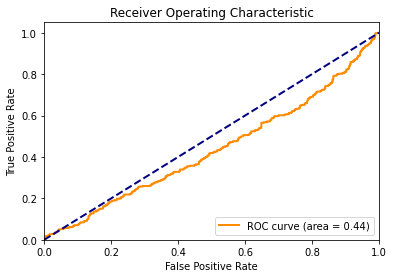

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.5236 - loss: 0.6898
Validation Loss: 0.6903025507926941
Validation Accuracy: 0.5142857432365417
Test Loss: 0.693463073944052
Inference Time (seconds): 2.6081581115722656
Test Accuracy: 0.5122222222222222
Confusion Matrix:
 [[461   0]
 [439   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.51      1.00      0.68       461
           1       0.00      0.00      0.00       439

    accuracy                           0.51       900
   macro avg       0.26      0.50      0.34       900
weighted avg       0.26      0.51      0.35       900

ROC AUC Score: 0.4366658596000573
Metrics saved successfully


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in scalar divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [50]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_3000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_3000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+Attention Mechanism+Dense

In [51]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Multiply
from tensorflow.keras.models import Model

# Define the custom CNN architecture with attention mechanism
input_layer = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(512, activation='relu')(x)
attention_probs = Dense(np.prod(x.shape[1:]), activation='softmax', name='attention_probs')(x)
attention_mul = Multiply()([x, attention_probs])
x = Dense(1, activation='sigmoid')(attention_mul)

# Create the model
model = Model(inputs=input_layer, outputs=x)

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 222, 222,  │        896 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 111, 111,  │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 109, 109,  │     18,496 │ max_pooling2d_16… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 54, 54,    │          0 │ conv2d_19[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 52, 52,    │     73,856 │ max_pooling2d_17… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 26, 26,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 86528)     │          0 │ max_pooling2d_18… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 256)       │ 22,151,424 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 512)       │    131,584 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_probs     │ (None, 512)       │    262,656 │ dense_12[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 512)       │          0 │ dense_12[0][0],   │
│                     │                   │            │ attention_probs[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │        513 │ multiply[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,639,425 (86.36 MB)

 Trainable params: 22,639,425 (86.36 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 331ms/step - accuracy: 0.5024 - loss: 0.6939 - val_accuracy: 0.4857 - val_loss: 0.6932
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 344ms/step - accuracy: 0.5235 - loss: 0.6931 - val_accuracy: 0.4857 - val_loss: 0.6932
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 335ms/step - accuracy: 0.5021 - loss: 0.6932 - val_accuracy: 0.4857 - val_loss: 0.6933
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 335ms/step - accuracy: 0.5086 - loss: 0.6931 - val_accuracy: 0.4857 - val_loss: 0.6931
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 333ms/step - accuracy: 0.5016 - loss: 0.6934 - val_accuracy: 0.4857 - val_loss: 0.6934
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 339ms/step - accuracy: 0.5162 - loss: 0.6928 - val_accuracy: 0.4857 - val_loss: 0.6880
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 343ms/step - accuracy: 0.5301 - loss: 0.6893 - val_accuracy: 0.4857 - val_loss: 0.6858
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 342ms/step - accuracy: 0.5075 - loss: 0.6817 - val_accu

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


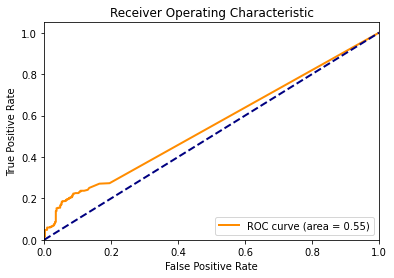

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.4764 - loss: 0.6962
Validation Loss: 0.6858202219009399
Validation Accuracy: 0.48571428656578064
Test Loss: 0.6851249278750684
Inference Time (seconds): 2.359600782394409
Test Accuracy: 0.48777777777777775
Confusion Matrix:
 [[  0 461]
 [  0 439]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       461
           1       0.49      1.00      0.66       439

    accuracy                           0.49       900
   macro avg       0.24      0.50      0.33       900
weighted avg       0.24      0.49      0.32       900

ROC AUC Score: 0.5512973183976598
Metrics saved successfully


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in scalar divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [53]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_3000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_3000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [54]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 343ms/step - accuracy: 0.5155 - loss: 0.6899 - val_accuracy: 0.4857 - val_loss: 0.6922
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 342ms/step - accuracy: 0.5022 - loss: 0.6883 - val_accuracy: 0.4857 - val_loss: 0.6853
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 341ms/step - accuracy: 0.5081 - loss: 0.6792 - val_accuracy: 0.4857 - val_loss: 0.6951
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 342ms/step - accuracy: 0.5116 - loss: 0.6872 - val_accuracy: 0.4857 - val_loss: 0.6933
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 341ms/step - accuracy: 0.4918 - loss: 0.6933 - val_accuracy: 0.4857 - val_loss: 0.6933
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 341ms/step - accuracy: 0.5029 - loss: 0.6931 - val_accuracy: 0.4857 - val_loss: 0.6934
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 341ms/step - accuracy: 0.4944 - loss: 0.6933 - val_accuracy: 0.4857 - val_loss: 0.6935
Training Time: 127.23326086997986 seconds


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


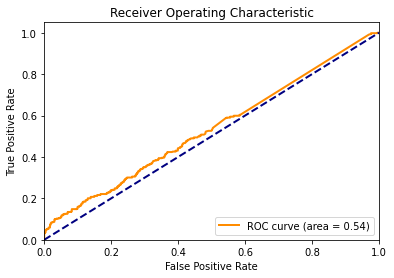

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.4764 - loss: 0.7042
Validation Loss: 0.6853278875350952
Validation Accuracy: 0.48571428656578064
Test Loss: 0.6847988377480457
Inference Time (seconds): 2.279510021209717
Test Accuracy: 0.48777777777777775
Confusion Matrix:
 [[  0 461]
 [  0 439]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       461
           1       0.49      1.00      0.66       439

    accuracy                           0.49       900
   macro avg       0.24      0.50      0.33       900
weighted avg       0.24      0.49      0.32       900

ROC AUC Score: 0.535134574239422
Metrics saved successfully


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in scalar divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [55]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_3000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_3000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [56]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 344ms/step - accuracy: 0.5249 - loss: 0.6805 - val_accuracy: 0.4857 - val_loss: 0.6806
Epoch 2/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 341ms/step - accuracy: 0.5106 - loss: 0.6830 - val_accuracy: 0.4857 - val_loss: 0.6761
Epoch 3/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 342ms/step - accuracy: 0.5079 - loss: 0.6978 - val_accuracy: 0.4857 - val_loss: 0.6924
Epoch 4/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 340ms/step - accuracy: 0.4998 - loss: 0.6876 - val_accuracy: 0.5524 - val_loss: 0.6868
Epoch 5/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 343ms/step - accuracy: 0.5562 - loss: 0.6875 - val_accuracy: 0.5929 - val_loss: 0.6758
Epoch 6/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 341ms/step - accuracy: 0.5468 - loss: 0.6784 - val_accuracy: 0.5905 - val_loss: 0.6773
Epoch 7/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 341ms/step - accuracy: 0.5565 - loss: 0.6981 - val_accuracy: 0.5857 - val_loss: 0.6759
Epoch 8/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 342ms/step - accuracy: 0.5362 - loss: 0.6848 - 

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


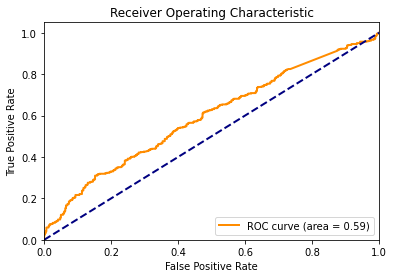

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5472 - loss: 0.6701
Validation Loss: 0.6445326209068298
Validation Accuracy: 0.5904762148857117
Test Loss: 0.6952775606630069
Inference Time (seconds): 2.3022594451904297
Test Accuracy: 0.5611111111111111
Confusion Matrix:
 [[230 231]
 [164 275]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.50      0.54       461
           1       0.54      0.63      0.58       439

    accuracy                           0.56       900
   macro avg       0.56      0.56      0.56       900
weighted avg       0.56      0.56      0.56       900

ROC AUC Score: 0.5931420750176649
Metrics saved successfully


In [57]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_3000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_3000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [58]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 344ms/step - accuracy: 0.6289 - loss: 0.6429 - val_accuracy: 0.5881 - val_loss: 0.6516
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 341ms/step - accuracy: 0.6031 - loss: 0.6342 - val_accuracy: 0.6095 - val_loss: 0.6553
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 341ms/step - accuracy: 0.6512 - loss: 0.6225 - val_accuracy: 0.5905 - val_loss: 0.6608
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 342ms/step - accuracy: 0.6252 - loss: 0.6196 - val_accuracy: 0.6238 - val_loss: 0.6786
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 341ms/step - accuracy: 0.6532 - loss: 0.6235 - val_accuracy: 0.6476 - val_loss: 0.6565
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 347ms/step - accuracy: 0.6983 - loss: 0.6001 - val_accuracy: 0.6381 - val_loss: 0.6659
Training Time: 109.43599724769592 seconds


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


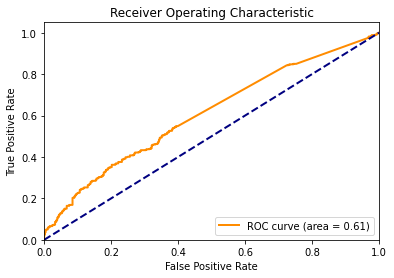

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5623 - loss: 0.6747
Validation Loss: 0.6515608429908752
Validation Accuracy: 0.5880952477455139
Test Loss: 0.694069095652368
Inference Time (seconds): 2.3381147384643555
Test Accuracy: 0.5777777777777777
Confusion Matrix:
 [[343 118]
 [262 177]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.74      0.64       461
           1       0.60      0.40      0.48       439

    accuracy                           0.58       900
   macro avg       0.58      0.57      0.56       900
weighted avg       0.58      0.58      0.56       900

ROC AUC Score: 0.6077878633652701
Metrics saved successfully


In [59]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_3000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_3000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+Capsule Network+Dense

In [60]:
from tensorflow.keras.layers import Layer, Input, Conv2D, MaxPooling2D, Flatten, Reshape, Dense
from tensorflow.keras.models import Model

# Define Capsule Layer
class CapsuleLayer(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        self.W = self.add_weight(shape=[input_dim_capsule, self.num_capsule * self.dim_capsule],
                                 initializer='glorot_uniform',
                                 name='W')

    def call(self, u_vecs):
        u_hat_vecs = tf.reduce_sum(tf.expand_dims(u_vecs, -1) * tf.expand_dims(self.W, 0), axis=-2)
        b = tf.zeros(shape=[tf.shape(u_hat_vecs)[0], self.num_capsule])
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=1)
            s_j = tf.reduce_sum(tf.multiply(c[:, :, None], u_hat_vecs), axis=1)
            v_j = self.squash(s_j)
            if i < self.routings - 1:
                b += tf.reduce_sum(tf.multiply(v_j[:, None, :], u_hat_vecs), axis=-1)
        return v_j

    def squash(self, s_j):
        s_squared_norm = tf.reduce_sum(tf.square(s_j), axis=-1, keepdims=True)
        scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())
        return scale * s_j

# Define your custom CNN architecture
input_tensor = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_tensor)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Reshape((-1, 128))(x)  # Reshape to 3D tensor for Capsule Network
capsule = CapsuleLayer(num_capsule=10, dim_capsule=16, routings=3)(x)  # Example: 10 capsules with dimension 16
capsule = Flatten()(capsule)  # Flatten the output
output = Dense(1, activation='sigmoid')(capsule)  # Use a single output unit for binary classification

# Create the full model
model = Model(inputs=input_tensor, outputs=output)

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_layer (CapsuleLayer)    │ (None, 160)            │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,189,601 (42.68 MB)

 Trainable params: 11,189,601 (42.68 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 290ms/step - accuracy: 0.4963 - loss: 0.6993 - val_accuracy: 0.5143 - val_loss: 0.6924
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 301ms/step - accuracy: 0.5117 - loss: 0.6940 - val_accuracy: 0.4929 - val_loss: 0.6926
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 291ms/step - accuracy: 0.5122 - loss: 0.6945 - val_accuracy: 0.4857 - val_loss: 0.6979
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 290ms/step - accuracy: 0.5264 - loss: 0.6925 - val_accuracy: 0.5143 - val_loss: 0.6929
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 288ms/step - accuracy: 0.4989 - loss: 0.6934 - val_accuracy: 0.4857 - val_loss: 0.6935
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 290ms/step - accuracy: 0.4938 - loss: 0.6936 - val_accuracy: 0.4881 - val_loss: 0.6930
Training Time: 98.95337009429932 seconds


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


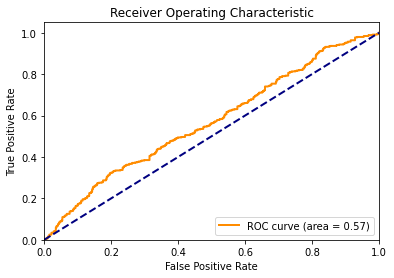

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5236 - loss: 0.6921
Validation Loss: 0.6924296617507935
Validation Accuracy: 0.5142857432365417
Test Loss: 0.6924926191568375
Inference Time (seconds): 2.3602328300476074
Test Accuracy: 0.5122222222222222
Confusion Matrix:
 [[461   0]
 [439   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.51      1.00      0.68       461
           1       0.00      0.00      0.00       439

    accuracy                           0.51       900
   macro avg       0.26      0.50      0.34       900
weighted avg       0.26      0.51      0.35       900

ROC AUC Score: 0.5695798477114721
Metrics saved successfully


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in scalar divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [62]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_3000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_3000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [63]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 290ms/step - accuracy: 0.5111 - loss: 0.6935 - val_accuracy: 0.5214 - val_loss: 0.6918
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 289ms/step - accuracy: 0.4884 - loss: 0.6947 - val_accuracy: 0.4857 - val_loss: 0.6932
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 291ms/step - accuracy: 0.5107 - loss: 0.6932 - val_accuracy: 0.4857 - val_loss: 0.6976
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 289ms/step - accuracy: 0.4905 - loss: 0.6960 - val_accuracy: 0.4857 - val_loss: 0.6939
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 290ms/step - accuracy: 0.5224 - loss: 0.6920 - val_accuracy: 0.5167 - val_loss: 0.6907
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 291ms/step - accuracy: 0.5152 - loss: 0.6929 - val_accuracy: 0.4857 - val_loss: 0.6958
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 290ms/step - accuracy: 0.5054 - loss: 0.6938 - val_accuracy: 0.4857 - val_loss: 0.6941
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 291ms/step - accuracy: 0.5078 - loss: 0.6936 - 

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step


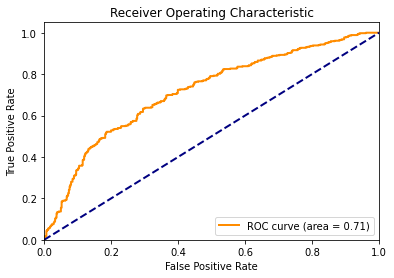

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6237 - loss: 0.6501
Validation Loss: 0.6228107213973999
Validation Accuracy: 0.6476190686225891
Test Loss: 0.6267625243299537
Inference Time (seconds): 2.2671854496002197
Test Accuracy: 0.6522222222222223
Confusion Matrix:
 [[263 198]
 [115 324]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.57      0.63       461
           1       0.62      0.74      0.67       439

    accuracy                           0.65       900
   macro avg       0.66      0.65      0.65       900
weighted avg       0.66      0.65      0.65       900

ROC AUC Score: 0.7149012496355848
Metrics saved successfully


In [64]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_3000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_3000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [65]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 291ms/step - accuracy: 0.6130 - loss: 0.6562 - val_accuracy: 0.6214 - val_loss: 0.6497
Epoch 2/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 290ms/step - accuracy: 0.6221 - loss: 0.6463 - val_accuracy: 0.5262 - val_loss: 0.7856
Epoch 3/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 291ms/step - accuracy: 0.6319 - loss: 0.6520 - val_accuracy: 0.7071 - val_loss: 0.5868
Epoch 4/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 290ms/step - accuracy: 0.7083 - loss: 0.5896 - val_accuracy: 0.6810 - val_loss: 0.5811
Epoch 5/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 289ms/step - accuracy: 0.7261 - loss: 0.5612 - val_accuracy: 0.6405 - val_loss: 0.5970
Epoch 6/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 289ms/step - accuracy: 0.7399 - loss: 0.5545 - val_accuracy: 0.6714 - val_loss: 0.5988
Epoch 7/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 290ms/step - accuracy: 0.6836 - loss: 0.5831 - val_accuracy: 0.6905 - val_loss: 0.5669
Epoch 8/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 291ms/step - accuracy: 0.7245 - loss: 0.5524 - 

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step


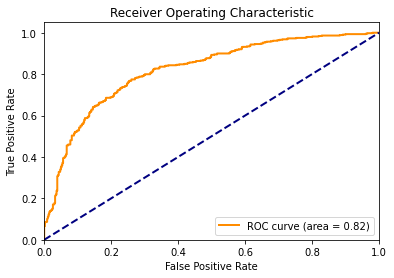

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.7085 - loss: 0.5506
Validation Loss: 0.5255782008171082
Validation Accuracy: 0.7357142567634583
Test Loss: 0.5223520392924548
Inference Time (seconds): 2.2751824855804443
Test Accuracy: 0.7455555555555555
Confusion Matrix:
 [[366  95]
 [134 305]]
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.79      0.76       461
           1       0.76      0.69      0.73       439

    accuracy                           0.75       900
   macro avg       0.75      0.74      0.74       900
weighted avg       0.75      0.75      0.74       900

ROC AUC Score: 0.8195415532243959
Metrics saved successfully


In [66]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_3000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_3000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [67]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 291ms/step - accuracy: 0.7833 - loss: 0.4832 - val_accuracy: 0.7167 - val_loss: 0.5349
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 289ms/step - accuracy: 0.7667 - loss: 0.4773 - val_accuracy: 0.7238 - val_loss: 0.5590
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 289ms/step - accuracy: 0.7726 - loss: 0.4900 - val_accuracy: 0.7119 - val_loss: 0.5353
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 293ms/step - accuracy: 0.7617 - loss: 0.4970 - val_accuracy: 0.7214 - val_loss: 0.5390
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 290ms/step - accuracy: 0.7795 - loss: 0.4739 - val_accuracy: 0.7310 - val_loss: 0.5439
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 291ms/step - accuracy: 0.7844 - loss: 0.4603 - val_accuracy: 0.7286 - val_loss: 0.5391
Training Time: 92.86718845367432 seconds


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step


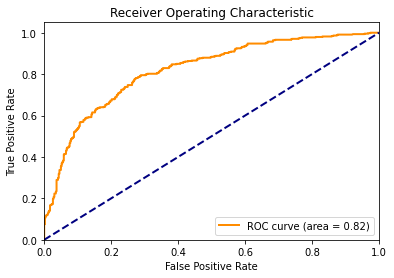

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6934 - loss: 0.5626
Validation Loss: 0.5348835587501526
Validation Accuracy: 0.7166666388511658
Test Loss: 0.5291611591643758
Inference Time (seconds): 2.2693915367126465
Test Accuracy: 0.7366666666666667
Confusion Matrix:
 [[371  90]
 [147 292]]
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.80      0.76       461
           1       0.76      0.67      0.71       439

    accuracy                           0.74       900
   macro avg       0.74      0.73      0.73       900
weighted avg       0.74      0.74      0.74       900

ROC AUC Score: 0.8178096541637225
Metrics saved successfully


In [68]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Check for extreme predicted probabilities
if np.any((y_pred <= 0) | (y_pred >= 1)):
    # Handle extreme probabilities by clipping
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid extremes
else:
    y_pred_clipped = y_pred

# Calculate test loss using stabilized log function
test_loss = log_loss(y_test_encoded, y_pred_clipped)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_3000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_3000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")